Lorenz curve in this case is where the slope of the line comparing the large-fire size and the fraction of total area burned captured by "large" fires = 1 (per the large fire threshold Excel file in the MS Teams). In this example I'll try to calculate a Lorenz curve using the fires from the FOD that intersect with PY136. This makes the target 18.0 acres (according to the same spreadsheet)

Conceptual steps
1. Data- PY136, FOD
2. Extract fire points that intersect with PY136
3. 

In [32]:
## calculate a Lorenz curve for PY136
import os
import geopandas as gpd
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt


In [15]:
## read in data sources
# fire occurrence
fod_gdb = r"C:\Users\Charlie\Desktop\ArcGIS\data\NatFSim\NatFSim2022\fire_occurrence\FPA_FOD_20221014.gdb"
fires = gpd.read_file(fod_gdb, layer="Fires")

# pyrome shapefiles
pyromes_path = r"C:\Users\Charlie\Desktop\ArcGIS\data\WCS_OPM_FY24\0_AnalysisArea\Pyromes\Pyromes_CONUS_20200206.shp"
pyrome_boundaries = gpd.read_file(pyromes_path)

In [23]:
# filter fire occurrence based on two min large-fire sizes: recorded in the excel spreadsheet (1.0 acres) and in the methods doc (72 acres)
# print(fires.columns)
# print(fires.shape)
# print(fires['FIRE_SIZE'].dtype)
fires_1ac = fires[fires["FIRE_SIZE"] >= 1]
print(fires_1ac.shape)
fires_72ac = fires[fires["FIRE_SIZE"] >= 72]
print(fires_72ac.shape)

# write the filtered points shapefiles to fire occurrence folder
fod_dir = r"C:\Users\Charlie\Desktop\ArcGIS\data\NatFSim\NatFSim2022\fire_occurrence"
fires_1ac.to_file(os.path.join(fod_dir, "fires_1ac.shp"))
fires_72ac.to_file(os.path.join(fod_dir, "fires_72ac.shp"))


(1137831, 38)
(82548, 38)


C:\Users\Charlie\AppData\Local\Temp\ipykernel_42752\1117682292.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fires_1ac.to_file(os.path.join(fod_dir, "fires_1ac.shp"))
C:\Users\Charlie\AppData\Local\Temp\ipykernel_42752\1117682292.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  fires_72ac.to_file(os.path.join(fod_dir, "fires_72ac.shp"))


export as a geopackage to preserve full field names ^

In [61]:
## test with just one pyrome
# filter for pyrome 17
PY_017 = pyrome_boundaries[pyrome_boundaries["PYROME"] == 17]
PY_017.head()
PY_017 = PY_017.to_crs(fires.crs)

# find fires that intersect with the pyrome
PY_017_fires = gpd.overlay(fires, PY_017, how='intersection')

In [62]:
PY_017_fires.shape
PY_017_fires.columns
PY_017_fires = PY_017_fires[['FIRE_SIZE', 'FOD_ID']]

cross-referenced this number with the intersection of the points and the polygon using ArcGIS, and they match

In [80]:
## calculating a lorenz curve
# sort by fire size
# PY_017_fires = PY_017_fires.sort_values(by='FIRE_SIZE').reset_index(drop=True)
PY_017_fires = PY_017_fires.sort_values(by='FIRE_SIZE', ascending=False).reset_index(drop=True)
print(PY_017_fires.head())

# calculate cumulative fires
PY_017_fires['cum_fires'] = (np.arange(1, len(PY_017_fires) + 1)) / len(PY_017_fires)
PY_017_fires['cum_fires_per'] = PY_017_fires['cum_fires'] * 100
print(PY_017_fires.head())

# calculate cumulative burned area
PY_017_fires['cum_area'] = PY_017_fires['FIRE_SIZE'].cumsum() / PY_017_fires['FIRE_SIZE'].sum()
PY_017_fires['cum_area_per'] = PY_017_fires['cum_area'] * 100
print(PY_017_fires.tail())


   FIRE_SIZE     FOD_ID  cum_fires  cum_fires_per  cum_area  cum_area_per  \
0   589368.0  400629554   1.000000     100.000000  1.000000    100.000000   
1   499945.0     155225   0.999958      99.995809  0.881715     88.171543   
2   328363.0  400629598   0.999916      99.991617  0.781378     78.137781   
3   229651.0  400302960   0.999874      99.987426  0.715476     71.547624   
4   191125.0  400008336   0.999832      99.983235  0.669386     66.938590   

         slope  
0  2822.151636  
1  2393.955219  
2  1572.345593  
3  1099.669384  
4   915.190053  
   FIRE_SIZE     FOD_ID  cum_fires  cum_fires_per  cum_area  cum_area_per  \
0   589368.0  400629554   0.000042       0.004191  1.000000    100.000000   
1   499945.0     155225   0.000084       0.008383  0.881715     88.171543   
2   328363.0  400629598   0.000126       0.012574  0.781378     78.137781   
3   229651.0  400302960   0.000168       0.016765  0.715476     71.547624   
4   191125.0  400008336   0.000210       0.020956 

interpretations:
1. cumulative fire percent- the percentage of data points that fall at and below this record. For example, the cumulative percentage of the 5th of 100 data points is 5%
2. cumulative sum of fire size- shows the sum of fire size for all records at and below that record

In [81]:
# print(PY_017_fires['FIRE_SIZE'].sum())
# print(PY_017_fires['FIRE_SIZE'].cumsum())

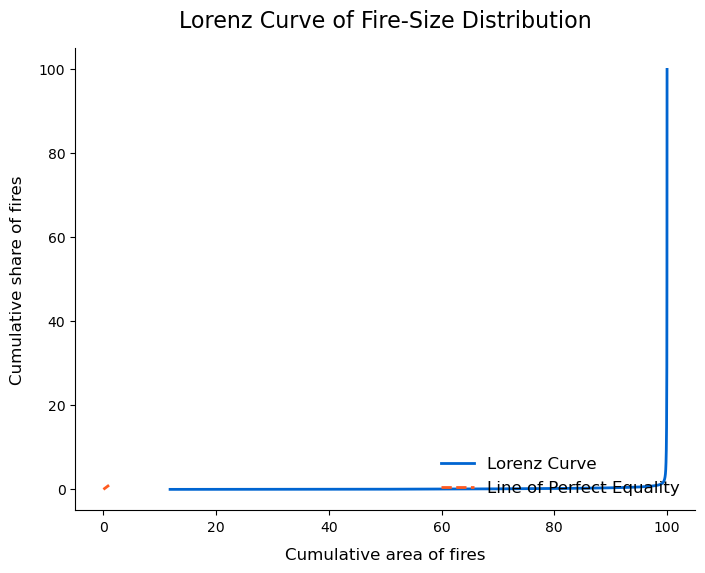

In [82]:
# plot the curve
x = PY_017_fires['cum_area_per']
y = PY_017_fires['cum_fires_per']

# Chicago Bears-inspired colors
blue = "#0065D1"  # Lighter blue for the Lorenz curve
orange = "#FF5A1F"  # Bright orange for the line of perfect equality

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the Lorenz curve
# This curve shows the inequality in crime distribution across neighborhoods
plt.plot(x, y, label="Lorenz Curve", color=blue, linewidth=2)

# Plot the line of perfect equality
# This line represents a hypothetical scenario where crimes are evenly distributed
plt.plot([0, 1], [0, 1], label="Line of Perfect Equality", color=orange, linestyle="--", linewidth=2)

# Add a title to explain what the graph represents
plt.title("Lorenz Curve of Fire-Size Distribution", fontsize=16, color="black", pad=15)

# Label the x-axis to show what the horizontal axis represents
plt.xlabel("Cumulative area of fires", fontsize=12, color="black", labelpad=10)

# Label the y-axis to show what the vertical axis represents
plt.ylabel("Cumulative share of fires", fontsize=12, color="black", labelpad=10)

# Add a legend to explain the two lines
plt.legend(fontsize=12, loc="lower right", frameon=False)

# Remove the grid for a cleaner look
plt.grid(False)

# Set the background color to white for a professional appearance
plt.gca().set_facecolor("white")

# Remove the top and right borders of the graph for a minimalist design
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Display the plot
plt.show()

In [83]:
## find where the slope of the line is closest to 1, or the minimum large-fire size threshold
# calculate difference vectors
# np.diff calculates the difference of each element with the element before it
dx = np.diff(PY_017_fires['cum_fires_per'])
dy = np.diff(PY_017_fires['cum_area_per'])

# calculate slope and replace NaN with 0
slope = dy / dx
slope = np.insert(slope, 0, np.nan)

# create a new dataFrame from the 2nd row onward (first calculated slope is nan)
PY_017_fires['slope'] = slope

# find the row at which the slope of the line is closest to 1
idx_1 = (PY_017_fires['slope'] - 1).abs().idxmin() # subtract 1 from each slope value, find the absolute value, find the index position of the minimum
row_1 = PY_017_fires.loc[idx_1]
print(row_1)


FIRE_SIZE           210.000000
FOD_ID           905801.000000
cum_fires             0.014208
cum_fires_per         1.420847
cum_area              0.991122
cum_area_per         99.112250
slope                 1.005572
Name: 338, dtype: float64


In pyrome 17, fires 210 acres and above account for 1.42% of fires and 99.1% of burned area

In [87]:
# turning it into a function to quickly test different pyromes
# requires pyrome number as a value - 1, 4, 17
def find_min_fire_size(pyrome):

    # select individual pyrome from the shapefile and ensure it's on the same crs as the FOD
    py = pyrome_boundaries[pyrome_boundaries["PYROME"] == pyrome]
    py = py.to_crs(fires.crs) # convert to an if statement to only do the conversion if the crs are different

    # find the fires that intersect with the pyrome
    py_fires = gpd.overlay(fires, py, how='intersection')
    py_fires = py_fires[['FIRE_SIZE', 'FOD_ID']]

    # sort descending by fire size
    py_fires = py_fires.sort_values(by='FIRE_SIZE', ascending=False).reset_index(drop=True)

    # calculate cumulative fires and %
    py_fires['cum_fires'] = (np.arange(1, len(py_fires) + 1)) / len(py_fires)
    py_fires['cum_fires_per'] = py_fires['cum_fires'] * 100

    # calculate cumulative burned area and %
    py_fires['cum_area'] = py_fires['FIRE_SIZE'].cumsum() / py_fires['FIRE_SIZE'].sum()
    py_fires['cum_area_per'] = py_fires['cum_area'] * 100

    # calculate difference vectors
    # np.diff calculates the difference of each element with the element before it
    dx = np.diff(py_fires['cum_fires_per'])
    dy = np.diff(py_fires['cum_area_per'])

    # calculate slope and replace NaN with 0
    slope = dy / dx
    slope = np.insert(slope, 0, np.nan)

    # create a new dataFrame from the 2nd row onward (first calculated slope is nan)
    py_fires['slope'] = slope

    # find the row at which the slope of the line is closest to 1
    idx_1 = (py_fires['slope'] - 1).abs().idxmin() # subtract 1 from each slope value, find the absolute value, find the index position of the minimum
    row_1 = py_fires.loc[idx_1]
    print(row_1)

In [89]:
find_min_fire_size(1)

FIRE_SIZE            5.100000
FOD_ID           19326.000000
cum_fires            0.049774
cum_fires_per        4.977376
cum_area             0.916553
cum_area_per        91.655320
slope                0.990582
Name: 857, dtype: float64


In [90]:
find_min_fire_size(2)

FIRE_SIZE            60.000000
FOD_ID           731511.000000
cum_fires             0.043895
cum_fires_per         4.389465
cum_area              0.981361
cum_area_per         98.136094
slope                 0.999596
Name: 109, dtype: float64


In [94]:
find_min_fire_size(49)

FIRE_SIZE        9.600000e+02
FOD_ID           4.003151e+08
cum_fires        8.268551e-02
cum_fires_per    8.268551e+00
cum_area         9.486480e-01
cum_area_per     9.486480e+01
slope            9.924658e-01
Name: 116, dtype: float64
